In [1]:
import time
import pandas as pd
import re
import numpy as np
from konlpy.tag import Kkma, Okt
from sklearn.model_selection import train_test_split
import kss
import time
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = '/home/bigdata/jupyter_notebook/wontae/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location)
plt.rc('font', family = font_name.get_name())
%matplotlib inline

In [2]:
import os
import re

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.engine.topology import Layer
from keras.layers import Dense, Input
from keras.layers import Embedding, GRU, Bidirectional, TimeDistributed
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from nltk import tokenize
import tensorflow as tf
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences




Using TensorFlow backend.
/home/bigdata/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bigdata/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bigdata/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bigdata/.conda/envs/py36/l

In [3]:
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
petition_data = pd.read_csv('petition.csv', encoding='utf-8')

,article_id,start,end,answered,votes,category,title,content
0,21,2017-08-19,2017-11-17,0,9,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...
1,22,2017-08-19,2017-11-17,0,17,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...
2,23,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."
3,24,2017-08-19,2017-08-26,0,53,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...
4,25,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."
5,26,2017-08-19,2017-08-26,0,2,보건복지,보건복지부 부령 제339호중 “특수의료장비 운영에 관한 규칙” 중 불합리한 행정제...,청원인 왕 기 운\n서울 도봉구 창동 삼성아파트 101-1103호\n청원취지\n보...
6,27,2017-08-19,2017-09-18,0,1,정치개혁,김이수 헌재소장 임명 재고 건의,문 대통령님께 묻습니다 (2017. 8. 19)\n저는 경기도 용인에 살고 있는 국...
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...
8,29,2017-08-19,2017-09-18,0,3,미래,문재인 정부는 왜 공무원개혁엔 무관심한가?,살충제 계란 사건으로 국민들을 불안케 하고 있다.\n원인이 무엇인가? 살충제를 뿌린...
9,30,2017-08-19,2017-11-17,0,1,일자리,A/S 기사들도 관심을 가져주십시요,안녕하세요. 저는 LG전자 서비스센터에서 근무하고 있는 서비스 기사입니다. 이곳에 ...


In [6]:
def title_content_combine(title,content):
    return title + ' ' + str(content)

In [7]:
petition_data['petition'] = petition_data.apply(lambda x : title_content_combine(x.title, x.content), axis = 1)

In [8]:
data = petition_data[['petition', 'category']]

In [9]:
max_nb_instances = 100000
x  = pd.DataFrame(data.petition)
y = pd.DataFrame(data.category)
y.columns = ['category']
x_train = x[:max_nb_instances]
y_train = y[:max_nb_instances]

In [10]:
kkma = Kkma()
okt = Okt()

In [10]:
def preprocess(text):
    text = text.replace('\n', '')
    t = re.sub('[^0-9a-zA-Zㄱ-힗,.!?""''\s]', '', text)
    return t

In [11]:
x['mod_petition'] = x.apply(lambda j : preprocess(j.petition), axis =1)

KeyboardInterrupt: 

In [ ]:
x_train = x.mod_petition[:max_nb_instances]
y_train = pd.DataFrame(y_train)

In [14]:
from keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 100000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x.mod_petition[:max_nb_instances])

In [ ]:
reviews = []
texts = []
for text in x_train:
    sentences =kss.split_sentences(text)
    for sen in sentences:
        texts.append(sen)
    reviews.append(sentences)

In [ ]:
MAX_SENTENCES = 15
MAX_SENTENCE_LENGTH = 100
X_train = np.zeros((max_nb_instances, MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='int32')
for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAX_SENTENCE_LENGTH and tokenizer.word_index[word] < MAX_NB_WORDS:
                    X_train[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

In [18]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 1309975 unique tokens.


In [19]:
def category_to_number(y_data):
    category_list = list(set(y_data.category))
    new_y = []
    for i, category in enumerate(y_data.category):
        new_y.append(category_list.index(category))
    ret = pd.DataFrame(new_y)
    ret.columns = ['category']
    return ret,category_list

In [16]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [20]:
y_train.columns = ['category']
Y_train,category_list = category_to_number(y_train)
Y_train = to_categorical(np.asarray(Y_train))

In [21]:

validation_split = 0.1
nb_validation_samples = int(validation_split * X_train.shape[0])

In [22]:
x_train = X_train[:-nb_validation_samples]
y_train = Y_train[:-nb_validation_samples]
x_val = X_train[-nb_validation_samples:]
y_val = Y_train[-nb_validation_samples:]

In [ ]:
result = []
for i, pet in enumerate(x.mod_petition[:max_nb_instances]):
    if i%5000==0: # 5,000의 배수로 While문이 실행될 때마다 몇 번째 While문 실행인지 출력.
        print("%d번째 for문."%i)
    tokenlist = okt.pos(pet, stem=True, norm=True) # 단어 토큰화
    temp=[]
    for word in tokenlist:
        if word[1] in ["Noun"]: # 명사일 때만
            temp.append((word[0])) # 해당 단어를 저장함

    if temp: # 만약 이번에 읽은 데이터에 명사가 존재할 경우에만
      result.append(temp) # 결과에 저장

In [ ]:
w2v_model = Word2Vec(result, size=embedding_dim, window=5, min_count=5, workers=4, sg=0)

In [ ]:
w2v_model.save('han_test_w2v-pre.model')

In [23]:
w2v_model = Word2Vec.load('han_test_w2v.model')
w2v_model = Word2Vec.load('han_test_w2v-pre.model')

In [24]:
def get_vector(word, word2vec_model):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [25]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in tokenizer.word_index.items():
    temp = get_vector(word, w2v_model)
    if temp is not None:
        embedding_matrix[i] = temp

/home/bigdata/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/bigdata/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
embedding_dim = 100
embedding_layer = Embedding(len(word_index) +1, embedding_dim, weights=[embedding_matrix], input_length = MAX_SENTENCE_LENGTH, trainable= True, mask_zero=True)
sentence_input = Input(shape=(MAX_SENTENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word) # word_attention
sentenceEncoder = Model(sentence_input, attn_word) #sentence_encoder

review_input = Input(shape=(MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='int32') # document_input
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(y_train.shape[1], activation='softmax')(attn_sentence)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 200)           131138400 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 200)           180600    
_________________________________________________________________
hierarchical_attention_netwo (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 17)                3417      
Total params: 131,342,617
Trainable params: 131,342,617
Non-trainable params: 0
_________________________________________________________________


In [28]:
print("model fitting - Hierachical attention network")
model.fit(x_train, y_train, validation_data=(x_val, y_val), nb_epoch=2, batch_size=512)

model fitting - Hierachical attention network


/home/bigdata/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
/home/bigdata/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:109: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 130997600 elements. This may consume a large amount of memory.
  num_elements)
/home/bigdata/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:109: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 130997600 elements. This may consume a large amount of memory.
  num_elements)


Train on 90000 samples, validate on 10000 samples
Epoch 1/2
90000/90000 [==============================] - 150s 2ms/step - loss: 1.8633 - acc: 0.4172 - val_loss: 1.8680 - val_acc: 0.4162
Epoch 2/2
90000/90000 [==============================] - 142s 2ms/step - loss: 1.3772 - acc: 0.5540 - val_loss: 1.7885 - val_acc: 0.4435


In [29]:
word_attention_extractor = Model(sentence_input, attn_word )
word_attentions = TimeDistributed(word_attention_extractor)(review_input)

attention_extractor = Model(review_input,outputs=[word_attentions, attn_sentence])




In [32]:
word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def category_analysis(review):    
    sentences = kss.split_sentences(review)
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=MAX_SENTENCE_LENGTH)
    pad_size = MAX_SENTENCES - tokenized_sentences.shape[0]

    if pad_size <= 0:
        tokenized_sentences = tokenized_sentences[:MAX_SENTENCES]
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0]
    for i, sentence in enumerate(tokenized_sentences[:-pad_size]):
        words = [word_rev_index[word_id] for word_id in sentence if word_id != 0][:50]
        pred_att = np.asarray(pred_attention[0][i][::-1][:len(words)][::-1])
        pred_att = np.expand_dims(pred_att, axis=0)

        fig, ax = plt.subplots(figsize=(len(words), 2))
        plt.rc('xtick', labelsize=22)
        heatmap = sn.heatmap(pred_att, xticklabels=words, square=True, linewidths=0.1)
        plt.xticks(rotation=70)
        plt.show()
        
        
    print((pred_attention))
    print(len(attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0]))
    print(attention_extractor.predict(np.asarray([tokenized_sentences]))[1])
        
#category_analysis("Delicious healthy food. The steak is amazing. Fish and pork are awesome too. Service is above and beyond. Not a bad thing to say about this place. Worth every penny!")

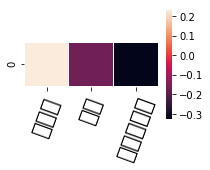

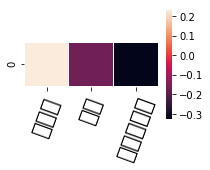

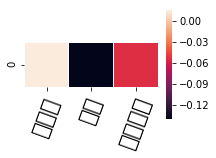

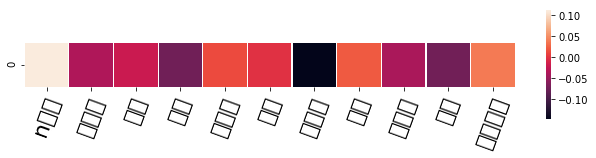

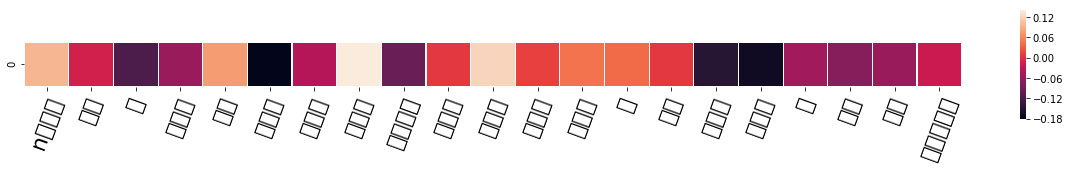

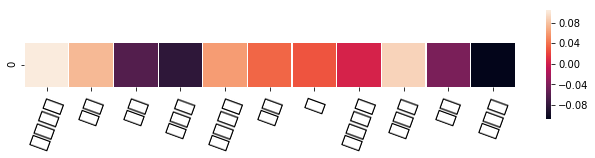

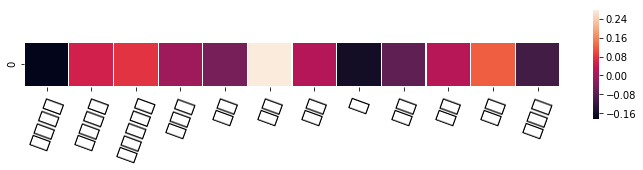

[[[-0.14669092  0.05139106 -0.01847914 ...  0.23030701 -0.1658525
   -0.3249192 ]
  [-0.14669092  0.05139106 -0.01847914 ...  0.23030701 -0.1658525
   -0.3249192 ]
  [-0.14505674  0.05286527 -0.01895004 ...  0.01435918 -0.14074805
   -0.05391624]
  ...
  [ 0.0117909  -0.03476062 -0.03675338 ... -0.00327088 -0.00939442
   -0.08364331]
  [-0.12749788 -0.04891206  0.01995264 ...  0.02042578  0.03606941
   -0.0059501 ]
  [ 0.10914107  0.12621592  0.03049387 ... -0.02943114 -0.01708826
    0.02579814]]]
200
[[-1.78450689e-01  2.63660550e-01  1.28870070e-01  9.96670052e-02
   3.79052967e-01 -3.71610373e-01  5.60277775e-02 -9.98720378e-02
   1.41248479e-01  1.59961477e-01 -2.47947693e-01 -2.44794637e-01
   2.95373261e-01  2.43019000e-01  3.65704775e-01  2.11954534e-01
  -2.88891315e-01  3.61485004e-01  3.23671848e-01 -5.60523421e-02
  -1.10036083e-01 -5.98831356e-01 -3.74448359e-01  3.52810055e-01
   3.44867885e-01  4.08269346e-01 -4.72491413e-01  3.26110162e-02
   2.35242635e-01  4.91075665e

In [33]:
category_analysis(data.petition[0])

In [ ]:
def encode_input(text):
    reviews = []
    texts = []
    entences =kss.split_sentences(text)
    for sen in sentences:
        texts.append(sen)
    reviews.append(sentences)
    
    
    
    
    ret = np.zeros((max_nb_instances, MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='int32')
    for i, sentences in enumerate(reviews):
        for j, sent in enumerate(sentences):
            if j < MAX_SENTENCES:
                wordTokens = text_to_word_sequence(sent)
                k = 0
                for _, word in enumerate(wordTokens):
                    if k < MAX_SENTENCE_LENGTH and tokenizer.word_index[word] < MAX_NB_WORDS:
                        ret[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
    return ret

In [ ]:
embedding_dim = 100
embedding_layer = Embedding(len(word_index) +1, embedding_dim, weights=[embedding_matrix], input_length = MAX_SENTENCE_LENGTH, trainable= True, mask_zero=True)
sentence_input = Input(shape=(MAX_SENTENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word) # word_attention
sentenceEncoder = Model(sentence_input, attn_word) #sentence_encoder

review_input = Input(shape=(MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='int32') # document_input
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(y_train.shape[1], activation='softmax')(attn_sentence)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])